# Obesity Dataset Analysis

Bu notebook, obezite veri seti üzerinde 3 farklı analiz gerçekleştirmektedir:
1. **Classification** - Obezite seviyelerinin sınıflandırılması
2. **Regression** - BMI tahmin modeli
3. **Clustering** - Kümeleme analizi

---
## 1. Classification (Sınıflandırma)

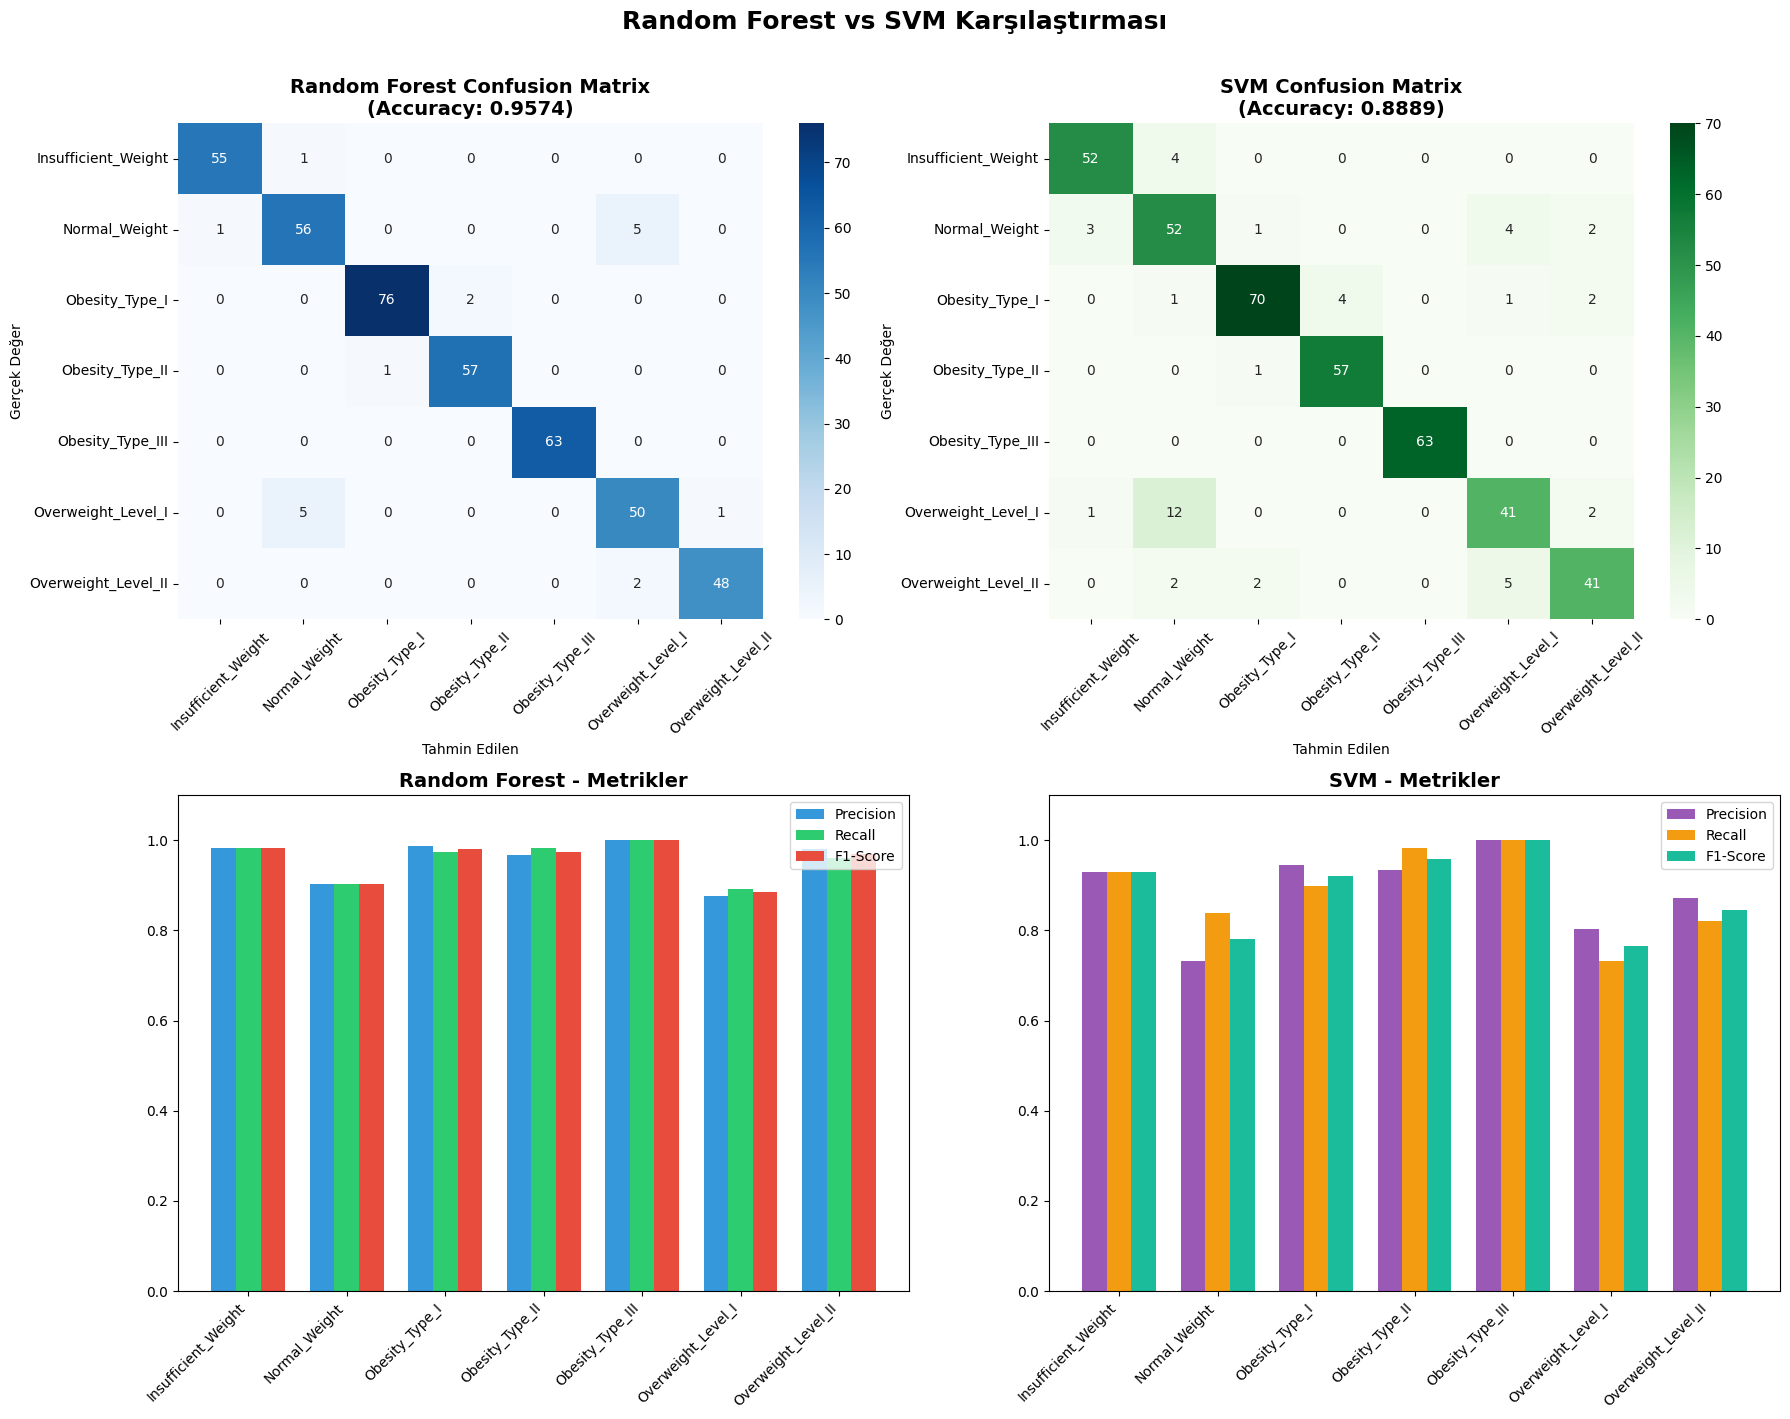


Random Forest Accuracy: 0.9574 | SVM Accuracy: 0.8889
En İyi: Random Forest


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df_raw = pd.read_csv("ObesityDataSet.csv")
df = df_raw.copy()

categorical_cols = ["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df["NObeyesdad"])
class_names = target_encoder.classes_
X = df.drop("NObeyesdad", axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred, target_names=class_names, output_dict=True)

# SVM
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
svm_cm = confusion_matrix(y_test, svm_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred, target_names=class_names, output_dict=True)

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title(f"Random Forest Confusion Matrix\n(Accuracy: {rf_accuracy:.4f})", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Tahmin Edilen"); axes[0, 0].set_ylabel("Gerçek Değer")
axes[0, 0].tick_params(axis="x", rotation=45)

sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names, ax=axes[0, 1])
axes[0, 1].set_title(f"SVM Confusion Matrix\n(Accuracy: {svm_accuracy:.4f})", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Tahmin Edilen"); axes[0, 1].set_ylabel("Gerçek Değer")
axes[0, 1].tick_params(axis="x", rotation=45)

x = np.arange(len(class_names)); width = 0.25
rf_f1 = [rf_report[c]["f1-score"] for c in class_names]
svm_f1 = [svm_report[c]["f1-score"] for c in class_names]

axes[1, 0].bar(x - width, [rf_report[c]["precision"] for c in class_names], width, label="Precision", color="#3498db")
axes[1, 0].bar(x, [rf_report[c]["recall"] for c in class_names], width, label="Recall", color="#2ecc71")
axes[1, 0].bar(x + width, rf_f1, width, label="F1-Score", color="#e74c3c")
axes[1, 0].set_title("Random Forest - Metrikler", fontsize=14, fontweight="bold")
axes[1, 0].set_xticks(x); axes[1, 0].set_xticklabels(class_names, rotation=45, ha="right"); axes[1, 0].legend(); axes[1, 0].set_ylim(0, 1.1)

axes[1, 1].bar(x - width, [svm_report[c]["precision"] for c in class_names], width, label="Precision", color="#9b59b6")
axes[1, 1].bar(x, [svm_report[c]["recall"] for c in class_names], width, label="Recall", color="#f39c12")
axes[1, 1].bar(x + width, svm_f1, width, label="F1-Score", color="#1abc9c")
axes[1, 1].set_title("SVM - Metrikler", fontsize=14, fontweight="bold")
axes[1, 1].set_xticks(x); axes[1, 1].set_xticklabels(class_names, rotation=45, ha="right"); axes[1, 1].legend(); axes[1, 1].set_ylim(0, 1.1)

plt.suptitle("Random Forest vs SVM Karşılaştırması", fontsize=18, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f} | SVM Accuracy: {svm_accuracy:.4f}")
print(f"En İyi: {'Random Forest' if rf_accuracy > svm_accuracy else 'SVM'}")

---
## 2. Regression (Regresyon)

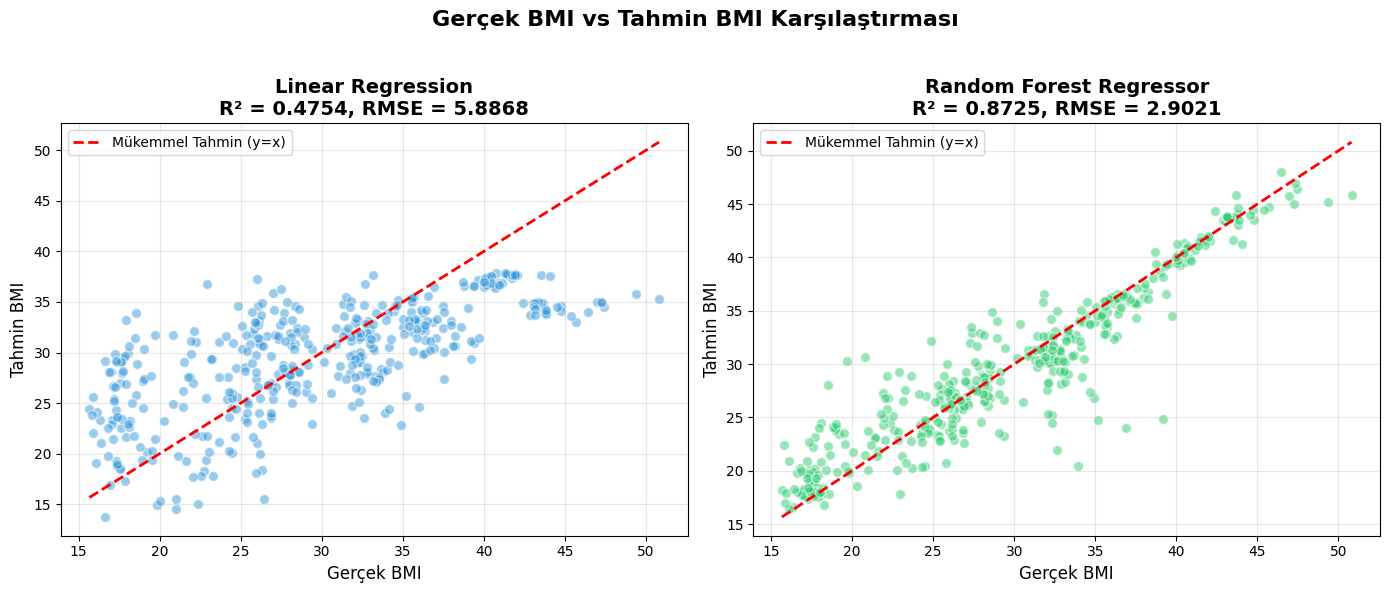

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def run_regression(csv_path: str) -> None:
    df = pd.read_csv(csv_path)

    # BMI
    df["BMI"] = df["Weight"] / (df["Height"] ** 2)

    categorical_cols = [
        "Gender", "family_history_with_overweight", "FAVC", "CAEC",
        "SMOKE", "SCC", "CALC", "MTRANS"
    ]

    # Encode categorical
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Avoid leakage: drop BMI target, label, and Weight/Height used in BMI formula
    X_reg = df.drop(["BMI", "NObeyesdad", "Weight", "Height"], axis=1)
    y_reg = df["BMI"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    lr_mae = mean_absolute_error(y_test, y_pred_lr)
    lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    lr_r2 = r2_score(y_test, y_pred_lr)

    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    rf_mae = mean_absolute_error(y_test, y_pred_rf)
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rf_r2 = r2_score(y_test, y_pred_rf)

    # Plot: True vs Predicted
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(y_test, y_pred_lr, alpha=0.5, color="#3498db", edgecolors="white", s=50)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 "r--", lw=2, label="Mükemmel Tahmin (y=x)")
    axes[0].set_xlabel("Gerçek BMI", fontsize=12)
    axes[0].set_ylabel("Tahmin BMI", fontsize=12)
    axes[0].set_title(f"Linear Regression\nR² = {lr_r2:.4f}, RMSE = {lr_rmse:.4f}",
                      fontsize=14, fontweight="bold")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(y_test, y_pred_rf, alpha=0.5, color="#2ecc71", edgecolors="white", s=50)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 "r--", lw=2, label="Mükemmel Tahmin (y=x)")
    axes[1].set_xlabel("Gerçek BMI", fontsize=12)
    axes[1].set_ylabel("Tahmin BMI", fontsize=12)
    axes[1].set_title(f"Random Forest Regressor\nR² = {rf_r2:.4f}, RMSE = {rf_rmse:.4f}",
                      fontsize=14, fontweight="bold")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("Gerçek BMI vs Tahmin BMI Karşılaştırması", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("bmi_regression_sonuclari.png", dpi=150, bbox_inches="tight")
    plt.show()


# Çalıştır
run_regression("ObesityDataSet.csv")

---
## 3. Clustering (Kümeleme)

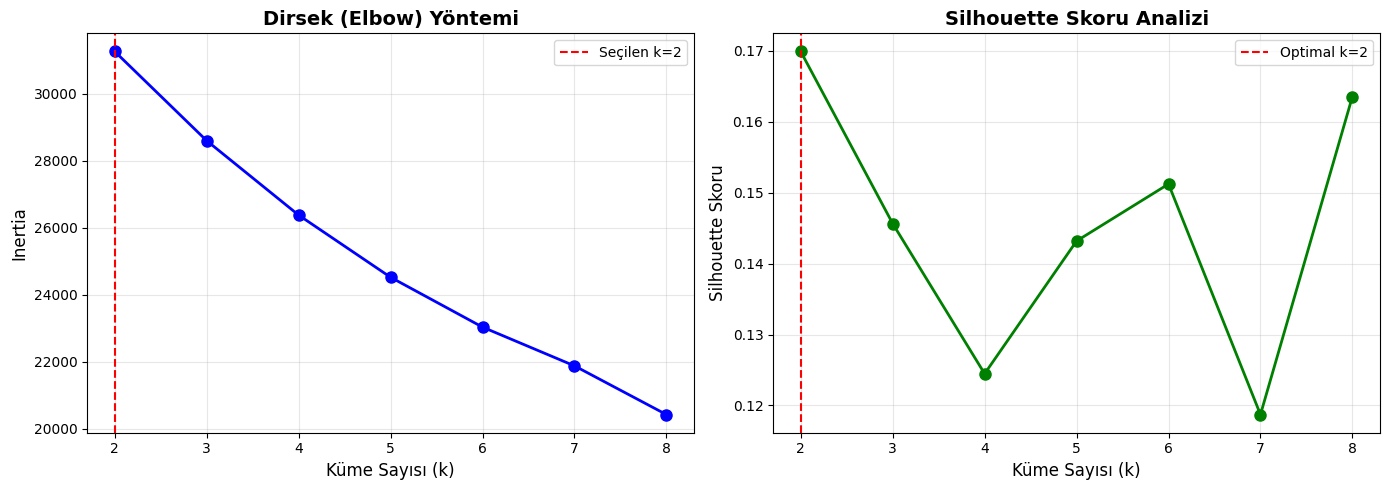


Hierarchical Clustering Silhouette Skoru (k=2): 0.1900

DBSCAN Sonuçları:
  - Bulunan küme sayısı: 12
  - Gürültü (noise) nokta sayısı: 299
  - Silhouette Skoru (gürültü hariç): 0.1262


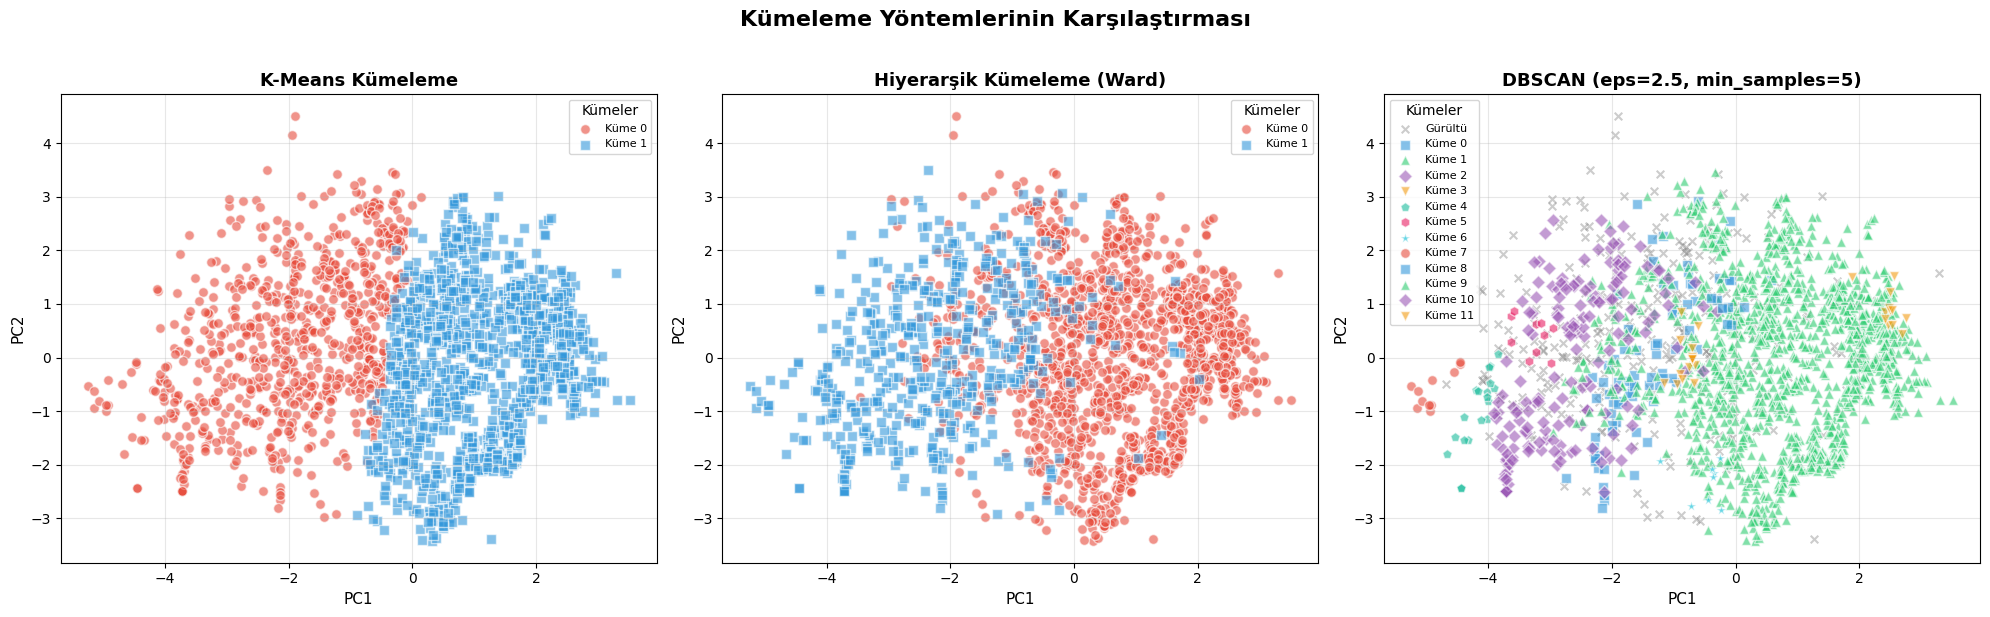


KÜMELEME YÖNTEMLERİ KARŞILAŞTIRMASI

1. K-Means:
   - Küme sayısı: 2
   - Silhouette Skoru: 0.1699

2. Hiyerarşik Kümeleme (Ward):
   - Küme sayısı: 2
   - Silhouette Skoru: 0.1900

3. DBSCAN:
   - Bulunan küme sayısı: 12
   - Gürültü nokta sayısı: 299
   - Silhouette Skoru: 0.1262


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


def run_clustering(csv_path: str) -> None:
    df = pd.read_csv(csv_path)

    # BMI
    df["BMI"] = df["Weight"] / (df["Height"] ** 2)

    categorical_cols = [
        "Gender", "family_history_with_overweight", "FAVC", "CAEC",
        "SMOKE", "SCC", "CALC", "MTRANS"
    ]

    # Encode categorical
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    cluster_features = [
        "Age", "Height", "Weight", "BMI", "Gender",
        "family_history_with_overweight", "FAVC", "FCVC", "NCP",
        "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"
    ]

    X_cluster = df[cluster_features]
    X_scaled = StandardScaler().fit_transform(X_cluster)

    # Elbow + Silhouette
    k_range = range(2, 9)
    inertias = []
    silhouettes = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X_scaled)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X_scaled, km.labels_))

    best_k = list(k_range)[int(np.argmax(silhouettes))]

    # Elbow ve Silhouette grafikleri
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(list(k_range), inertias, "bo-", linewidth=2, markersize=8)
    axes[0].set_xlabel("Küme Sayısı (k)", fontsize=12)
    axes[0].set_ylabel("Inertia", fontsize=12)
    axes[0].set_title("Dirsek (Elbow) Yöntemi", fontsize=14, fontweight="bold")
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=best_k, color="r", linestyle="--", label=f"Seçilen k={best_k}")
    axes[0].legend()

    axes[1].plot(list(k_range), silhouettes, "go-", linewidth=2, markersize=8)
    axes[1].set_xlabel("Küme Sayısı (k)", fontsize=12)
    axes[1].set_ylabel("Silhouette Skoru", fontsize=12)
    axes[1].set_title("Silhouette Skoru Analizi", fontsize=14, fontweight="bold")
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(x=best_k, color="r", linestyle="--", label=f"Optimal k={best_k}")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Final KMeans
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df["Cluster_Label"] = kmeans_final.fit_predict(X_scaled)

    # PCA 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    df["PC1"] = X_pca[:, 0]
    df["PC2"] = X_pca[:, 1]

    colors = ["#e74c3c", "#3498db", "#2ecc71", "#9b59b6", "#f39c12", "#1abc9c", "#e91e63", "#00bcd4"]
    markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

    # =====================================================================
    # HIERARCHICAL CLUSTERING (Hiyerarşik Kümeleme)
    # =====================================================================

    hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
    df["Hierarchical_Label"] = hierarchical.fit_predict(X_scaled)
    
    hierarchical_silhouette = silhouette_score(X_scaled, df["Hierarchical_Label"])
    print(f"\nHierarchical Clustering Silhouette Skoru (k={best_k}): {hierarchical_silhouette:.4f}")

    # =====================================================================
    # DBSCAN (Yoğunluk Tabanlı Kümeleme)
    # =====================================================================
    
    dbscan = DBSCAN(eps=2.5, min_samples=5)
    df["DBSCAN_Label"] = dbscan.fit_predict(X_scaled)
    
    n_clusters_dbscan = len(set(df["DBSCAN_Label"])) - (1 if -1 in df["DBSCAN_Label"].values else 0)
    n_noise = (df["DBSCAN_Label"] == -1).sum()
    
    print(f"\nDBSCAN Sonuçları:")
    print(f"  - Bulunan küme sayısı: {n_clusters_dbscan}")
    print(f"  - Gürültü (noise) nokta sayısı: {n_noise}")
    
    # DBSCAN için silhouette (gürültü noktaları hariç)
    if n_clusters_dbscan > 1:
        mask_no_noise = df["DBSCAN_Label"] != -1
        if mask_no_noise.sum() > 0:
            dbscan_silhouette = silhouette_score(X_scaled[mask_no_noise], df.loc[mask_no_noise, "DBSCAN_Label"])
            print(f"  - Silhouette Skoru (gürültü hariç): {dbscan_silhouette:.4f}")
    
    # =====================================================================
    # ÜÇ YÖNTEMİN KARŞILAŞTIRMALI GÖRSELLEŞTİRMESİ
    # =====================================================================
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # K-Means
    for i in range(best_k):
        mask = df["Cluster_Label"] == i
        axes[0].scatter(df.loc[mask, "PC1"], df.loc[mask, "PC2"],
            c=colors[i % len(colors)], marker=markers[i % len(markers)],
            label=f"Küme {i}", alpha=0.6, s=50, edgecolors="white")
    axes[0].set_xlabel("PC1", fontsize=11)
    axes[0].set_ylabel("PC2", fontsize=11)
    axes[0].set_title("K-Means Kümeleme", fontsize=13, fontweight="bold")
    axes[0].legend(title="Kümeler", loc="best", fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Hierarchical Clustering
    for i in range(best_k):
        mask = df["Hierarchical_Label"] == i
        axes[1].scatter(df.loc[mask, "PC1"], df.loc[mask, "PC2"],
            c=colors[i % len(colors)], marker=markers[i % len(markers)],
            label=f"Küme {i}", alpha=0.6, s=50, edgecolors="white")
    axes[1].set_xlabel("PC1", fontsize=11)
    axes[1].set_ylabel("PC2", fontsize=11)
    axes[1].set_title("Hiyerarşik Kümeleme (Ward)", fontsize=13, fontweight="bold")
    axes[1].legend(title="Kümeler", loc="best", fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    # DBSCAN
    unique_labels = sorted(df["DBSCAN_Label"].unique())
    for i, label in enumerate(unique_labels):
        mask = df["DBSCAN_Label"] == label
        if label == -1:
            axes[2].scatter(df.loc[mask, "PC1"], df.loc[mask, "PC2"],
                c="gray", marker="x", label="Gürültü", alpha=0.4, s=30)
        else:
            axes[2].scatter(df.loc[mask, "PC1"], df.loc[mask, "PC2"],
                c=colors[i % len(colors)], marker=markers[i % len(markers)],
                label=f"Küme {label}", alpha=0.6, s=50, edgecolors="white")
    axes[2].set_xlabel("PC1", fontsize=11)
    axes[2].set_ylabel("PC2", fontsize=11)
    axes[2].set_title(f"DBSCAN (eps=2.5, min_samples=5)", fontsize=13, fontweight="bold")
    axes[2].legend(title="Kümeler", loc="best", fontsize=8)
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle("Kümeleme Yöntemlerinin Karşılaştırması", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Özet istatistikler
    print("\n" + "="*60)
    print("KÜMELEME YÖNTEMLERİ KARŞILAŞTIRMASI")
    print("="*60)
    print(f"\n1. K-Means:")
    print(f"   - Küme sayısı: {best_k}")
    print(f"   - Silhouette Skoru: {silhouettes[best_k-2]:.4f}")
    
    print(f"\n2. Hiyerarşik Kümeleme (Ward):")
    print(f"   - Küme sayısı: {best_k}")
    print(f"   - Silhouette Skoru: {hierarchical_silhouette:.4f}")
    
    print(f"\n3. DBSCAN:")
    print(f"   - Bulunan küme sayısı: {n_clusters_dbscan}")
    print(f"   - Gürültü nokta sayısı: {n_noise}")
    if n_clusters_dbscan > 1 and mask_no_noise.sum() > 0:
        print(f"   - Silhouette Skoru: {dbscan_silhouette:.4f}")
    print("="*60)


# Çalıştır
run_clustering("ObesityDataSet.csv")